In [1]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import xgboost
import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, \
                            precision_recall_curve, average_precision_score, roc_auc_score, roc_curve, auc, accuracy_score, matthews_corrcoef

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn import preprocessing

from sklearn.exceptions import ConvergenceWarning
import warnings

from imblearn.over_sampling import RandomOverSampler

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pathlib import Path

import shap

import time

# dataset params

In [2]:
# path to the data file
data_file_loc = Path('/disks/data/datasets/ADNI/')

# load the dataset into dataframe
raw_df = pd.read_csv(data_file_loc/'ADNI Data SPSS-CSV.csv')

In [3]:
# features + target
col_names = list(raw_df.columns)
print(col_names)

['GENDER', 'maritalstatus', 'APOE4', 'ADASQ4_bl', 'DX', 'AGE', 'FDG_bl', 'CDRSB_bl', 'ADAS11_bl', 'ADAS13_bl', 'MMSE_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl', 'Ventricles_bl', 'Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl', 'MidTemp_bl']


# shuffle the dataset

In [4]:
df = raw_df.sample(frac=1).reset_index(drop=True)
df.head()

,GENDER,maritalstatus,APOE4,ADASQ4_bl,DX,AGE,FDG_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,...,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl
0,Female,Married,0,2,CN,83.3,1.227286,0.0,6.33,10.33,...,57.0,7.0,1.0,7.14286,40274.12831,6794.012692,1020753.123,3485.98162,17303.26072,19450.01906
1,Male,Divorced,0,3,CN,76.8,1.392750,0.0,3.00,6.00,...,41.0,7.0,7.0,58.33330,39227.00000,7369.000000,979865.000,4091.00000,15155.00000,18776.00000
2,Male,Married,0,3,MCI,72.0,1.204720,2.5,9.00,13.00,...,57.0,5.0,14.0,100.00000,40274.12831,6794.012692,1020753.123,3485.98162,17303.26072,19450.01906
3,Male,Married,0,2,CN,77.3,1.227286,0.0,8.00,10.00,...,44.0,6.0,2.0,18.18180,31812.00000,6794.012692,990398.000,3485.98162,17303.26072,19450.01906
4,Female,Married,0,10,MCI,80.0,1.227286,1.0,10.00,22.00,...,36.0,6.0,10.0,90.90910,22274.00000,6794.012692,1040250.000,3485.98162,17303.26072,19450.01906


In [5]:
# class frequency
from collections import Counter
print(sorted(Counter(df.DX).items()))

[('CN', 819), ('Dementia', 399), ('MCI', 1050)]


# oversample

In [6]:
# oversample to balance the dataset
ros = RandomOverSampler(random_state=0)
df_resampled, y_resampled = ros.fit_resample(df, df.DX)

# shufle the oversampled dataset
df_resampled = df_resampled.sample(frac=1).reset_index(drop=True)
df.head()

# verify class frequency after oversampling
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[('CN', 1050), ('Dementia', 1050), ('MCI', 1050)]


# manage column names

In [7]:
# list of the categorical and continuous columns
cat_names = ['GENDER','maritalstatus']
cont_names = col_names.copy()

# remove the target columns' name    
cont_names.remove('DX')

# remove the categorial columns' names
for cat_col in cat_names:
    cont_names.remove(cat_col)
cat_names, cont_names

(['GENDER', 'maritalstatus'],
 ['APOE4',
  'ADASQ4_bl',
  'AGE',
  'FDG_bl',
  'CDRSB_bl',
  'ADAS11_bl',
  'ADAS13_bl',
  'MMSE_bl',
  'RAVLT_immediate_bl',
  'RAVLT_learning_bl',
  'RAVLT_forgetting_bl',
  'RAVLT_perc_forgetting_bl',
  'Ventricles_bl',
  'Hippocampus_bl',
  'WholeBrain_bl',
  'Entorhinal_bl',
  'Fusiform_bl',
  'MidTemp_bl'])

# convert categorical columns to one-hot encodings

In [8]:
df_ohe = df_resampled.copy()
for cat_col in cat_names:
    df_ohe = pd.get_dummies(df_ohe, columns=[cat_col])
df_ohe.head()

,APOE4,ADASQ4_bl,DX,AGE,FDG_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,MMSE_bl,RAVLT_immediate_bl,...,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,GENDER_Female,GENDER_Male,maritalstatus_Divorced,maritalstatus_Married,maritalstatus_Never married,maritalstatus_Widowed
0,1,2,CN,70.3,1.290120,0.0,5.33,7.33,25,44.0,...,1139620.000,4430.00000,21634.00000,21476.00000,0,1,0,1,0,0
1,1,5,MCI,61.6,1.306450,2.0,9.00,16.00,28,40.0,...,944652.000,3328.00000,17769.00000,19298.00000,1,0,0,1,0,0
2,0,2,CN,58.3,1.227286,0.0,6.67,9.67,30,36.0,...,1020753.123,3485.98162,17303.26072,19450.01906,1,0,0,1,0,0
3,1,4,CN,83.9,1.227286,0.0,15.33,20.33,30,32.0,...,1020753.123,3485.98162,17303.26072,19450.01906,0,1,0,0,0,1
4,1,5,CN,80.2,1.223150,0.0,3.00,10.00,29,36.0,...,1022610.000,4313.00000,19821.00000,17272.00000,0,1,0,0,1,0


# normalize numerical features 

In [9]:
# normalize the continuous columns
for cont_name in cont_names:
    df_ohe[cont_name] = (df_ohe[cont_name] - min(df_ohe[cont_name]) )/(max(df_ohe[cont_name]) - min(df_ohe[cont_name]))

# verify that columns are normalized
print('max\tmin\tavg')
for cont_name in cont_names:
    print(f"{max(df_ohe[cont_name])}\t{min(df_ohe[cont_name])}\t{np.mean(df_ohe[cont_name])}")

max	min	avg
1.0	0.0	0.2704761904761905
1.0	0.0	0.5552698412698417
1.0	0.0	0.5170765634131284
1.0	0.0	0.5110743354020888
1.0	0.0	0.19955555555555562
1.0	0.0	0.29473244995368414
1.0	0.0	0.3505664445136612
1.0	0.0	0.7402686202686161
1.0	0.0	0.4823479769976304
1.0	0.0	0.6003964945623195
1.0	0.0	0.7500685971341605
1.0	0.0	0.9216049382058698
1.0	0.0	0.2563112329842766
1.0	0.0	0.4732551582849352
1.0	0.0	0.4213738065862404
1.0	0.0	0.4426076020652566
1.0	0.0	0.38516950401699135
1.0	0.0	0.4293927068374835


In [10]:
# show the row count for the target labels (should be same now that the dataset is balanced)
df_ohe.DX.value_counts()['CN'], df_ohe.DX.value_counts()['MCI'], df_ohe.DX.value_counts()['Dementia']


(1050, 1050, 1050)

In [11]:
# compute sample weights and class weights (unused)
sample_weights = compute_sample_weight(class_weight='balanced', y=df_ohe.DX)
class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(df_ohe.DX), y=df_ohe.DX)

class_weights_dict_label = dict(zip(np.unique(df_ohe.DX),class_weights))
class_weights_dict_label_enc = dict(zip(range(3),class_weights))
class_weights

array([1., 1., 1.])

In [12]:
# datasets for One-vs-All /pairwise classifications (used)

# df_ohe_CN_Demen = df_ohe.loc[df['DX'].isin(['CN','Dementia'])]
# # verify label-reassignment
# print(df_ohe_CN_Demen['DX'].unique(), df_ohe_MCI_Demen['DX'].unique(), df_ohe_CN_MCI['DX'].unique())

# # datasets for one vs all classifications
# df_ohe_CN_vs_all = df_ohe.copy()
# df_ohe_CN_vs_all = df_ohe_CN_vs_all.replace(['MCI','Dementia'],'Non')

# # verify label-reassignment
# print(df_ohe_CN_vs_all['DX'].unique(), df_ohe_MCI_vs_all['DX'].unique(), df_ohe_Demen_vs_all['DX'].unique())

# Metrics

In [13]:
# class for managing benchmark and performance metrics
class Metrics:
    
    def __init__(self, benchmark_acc = None, benchmark_f1 = None, benchmark_spec = None, benchmark_sen = None, benchmark_auc = None, benchmark_mcc = None):
        self.b_accuracy = benchmark_acc
        self.b_f1 = benchmark_f1
        self.b_sensitivity = benchmark_sen
        self.b_specificity = benchmark_spec
        self.b_auc_roc = benchmark_auc
        self.b_mcc = benchmark_mcc
        
    def reset_history(self):
        self.accuracies = []
        self.f1s = []
        self.recalls = []
        self.precisions = []
        self.sensitivity = []
        self.specificity = []
        self.auc_roc = []        
        self.tp_tn_fp_fn = []
        self.mcc = []

        
    metrics_names = ('acc','mcc',)# 'specificity', 'sensitivity', 'f1_score', 'auc_roc', 'recall', 
                     #'precision', 'mcc',  'tp','fp','tn','fn')
    @classmethod
    def compute_mcc(cls, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        mcc = (tp*tn - fp*fn) / (np.sqrt(  (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)  ) + 1e-8) 
        return mcc
    
    @classmethod
    def compute_sensitivity(cls, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp/(tp+fn)
        return sensitivity
    
    @classmethod
    def compute_specificity(cls, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn/(fp+tn)
        return specificity
    
    @classmethod
    def compute_accuracy(cls, y_true, y_pred):
        accuracy = (y_true==y_pred).sum()/len(y_true)
        return accuracy
    
    def compute_metrics(self, y_true, y_pred, label_list, epoch, do_print = False, store_vals = False):
        accuracy = (y_true==y_pred).sum()/len(y_true)
        mcc = matthews_corrcoef(y_true, y_pred)
        
        # for binary classification (unused)
        #cm = confusion_matrix(y_true, y_pred, labels = label_list)
        #tn, fp, fn, tp = cm.ravel()
        #specificity = tn/(fp+tn)
        #sensitivity = tp/(tp+fn)
        #f1 = f1_score(y_true, y_pred)
        #recall = recall_score(y_true, y_pred)
        #precision = precision_score(y_true, y_pred)
        #auc_roc = roc_auc_score( y_true, y_pred )  
        #mcc = (tp*tn - fp*fn) / (np.sqrt(  (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)  ) + 1e-8) 
        
        metrics_vals = ( accuracy, mcc, )# specificity, sensitivity, f1, auc_roc, recall, precision, mcc, tp, fp, tn, fn )

        results = ( metrics_names, metrics_vals )        
        
        return results
    
    

In [14]:
# metrics_names = Metrics.metrics_names
# clf_metrics = [ i+'_'+j for j in metrics_names for i in classifier_namelist+NN_labels ]
# clf_metrics

In [15]:
# np.array([[1,2],[3,4]]).transpose().reshape(1,-1)
# tmp, inner_CV_results_df

# Experiment params and configs

In [16]:
# parameters for NN training

NN_params = [ #{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0, 'learning_rate_init': 0.2},
              #{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9, 'nesterovs_momentum': False, 'learning_rate_init': 0.2},
              #{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9, 'nesterovs_momentum': True, 'learning_rate_init': 0.2},
              #{'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0, 'learning_rate_init': 0.2},
              #{'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9, 'nesterovs_momentum': True, 'learning_rate_init': 0.2},
              #{'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9, 'nesterovs_momentum': False, 'learning_rate_init': 0.2},
              {'solver': 'adam', 'learning_rate_init': 0.01},
              #{'solver': 'adam', 'learning_rate': 'invscaling', 'learning_rate_init': 0.01}
            ]

# labels for NN classifier for different param configs
NN_labels = [ #"constant learning-rate", 
              #"constant with momentum",
              #"constant with Nesterov's momentum",
              #"inv-scaling learning-rate", 
              #"inv-scaling with momentum",
              #"inv-scaling with Nesterov's momentum", 
              "NN_Adam",
             # "NN_Adam_inv_scaling_LR"
            ]

# maximum number of iterations for NN training
NN_max_iter = 100

# LightGBM training parameters
lgb_params  = {
          "objective" : "multiclass",
          "num_class" : 4,
          "num_leaves" : 60,
          "max_depth": -1,
          "learning_rate" : 0.01,
          "bagging_fraction" : 0.9,  # subsample
          "feature_fraction" : 0.9,  # colsample_bytree
          "bagging_freq" : 5,        # subsample_freq
          "bagging_seed" : 2018,
          "verbosity" : -1 }

# names of the classifiers (except for NN)
classifier_namelist = [ "RF", "SVM", "LDA", "XGBoost", "LightGBM"]

# setup the inner and outer k-fold 
num_split_outer = 10
num_split_inner = 10
skf_outer = StratifiedKFold(n_splits = num_split_outer)
skf_inner = StratifiedKFold(n_splits = num_split_inner)

# Format the data

In [17]:
# create the input matrix by dropping the target column from the dataset
X = (
        df_ohe
        .drop(['DX'], axis=1)
        .astype(float)
    )

# the target column
y = df_ohe.DX
label_list = sorted(y.unique()) 

# Label Encoding

In [18]:
# label encode the target variable
le = preprocessing.LabelEncoder()
le.fit(y)

y_label_enc = le.transform(y)
y_inv_str = le.inverse_transform(y_label_enc)

class_idx_to_name = dict(zip(range(len(le.classes_)),le.classes_))

# verify label encoding works as expected and show class label ordering for label encodings
np.unique(df_ohe.DX), le.classes_, label_list, (y == y_inv_str).unique(), class_idx_to_name

(array(['CN', 'Dementia', 'MCI'], dtype=object),
 array(['CN', 'Dementia', 'MCI'], dtype=object),
 ['CN', 'Dementia', 'MCI'],
 array([ True]),
 {0: 'CN', 1: 'Dementia', 2: 'MCI'})

In [19]:
# Make sure the data doesn't have any NaNs (unused) 
#np.any(np.isnan(X)), np.all(np.isfinite(X)), type(df_ohe)
#df_ohe.to_csv("df_ohe.csv")


# SHAP Plots

In [20]:
def save_shap_plots(model, X_test, class_idx_to_name):
    
    if (isinstance(model, RandomForestClassifier)): 
        
        classifier_name_abbr = 'rf'

        start_time_shap = time.time()
        explainer = shap.KernelExplainer(model.predict_proba, X_test)

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", module="shap")
            shap_values = explainer.shap_values(X_test, nsamples = 40) #nsamples='auto')

        end_time_shap = time.time()
        print(f'Shap Elapsed Time: {end_time_shap - start_time_shap}')  
        
        
    elif (isinstance(model, svm.SVC)):
        
        classifier_name_abbr = 'svm'

        start_time_shap = time.time()
        explainer = shap.KernelExplainer(model.predict_proba, X_test, link="logit")
    
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", module="shap")
            shap_values = explainer.shap_values(X_test, nsamples = 30)

        end_time_shap = time.time()
        print(f'Shap Elapsed Time: {end_time_shap - start_time_shap}')        
        
    elif (isinstance(model, LinearDiscriminantAnalysis)):
    
        classifier_name_abbr = 'lda'

        start_time_shap = time.time()
        explainer = shap.KernelExplainer(model.predict_proba, X_test, link="logit")
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", module="shap")
            shap_values = explainer.shap_values(X_test, nsamples=100)

        end_time_shap = time.time()
        print(f'Shap Elapsed Time: {end_time_shap - start_time_shap}')        
        
        
    elif (isinstance(model, xgboost.XGBClassifier)):
    
        classifier_name_abbr = 'xgboost'

        start_time_shap = time.time()
        explainer = shap.TreeExplainer(xgb)

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", module="shap")
            shap_values = explainer.shap_values(X_test)

        end_time_shap = time.time()
        print(f'Shap Elapsed Time: {end_time_shap - start_time_shap}')   
        
        
        
    elif (isinstance(model, lgb.LGBMClassifier)):
    
        classifier_name_abbr = 'lightGBM'

        start_time_shap = time.time()
        explainer = shap.TreeExplainer(model)

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", module="shap")
            shap_values = explainer.shap_values(X_test)

        end_time_shap = time.time()
        print(f'Shap Elapsed Time: {end_time_shap - start_time_shap}')
 
    
    elif (isinstance(model, MLPClassifier)):
        
        classifier_name_abbr = 'NN'

        start_time_shap = time.time()
        explainer = shap.KernelExplainer(model.predict_proba, X_test)

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", module="shap")
            shap_values = explainer.shap_values(X_test, nsamples=80)

        end_time_shap = time.time()
        print(f'Shap Elapsed Time: {end_time_shap - start_time_shap}')

        
        
    # Generate the summary plot, the force plots and the dependence plots
    
#     f = plt.figure()
#     shap.summary_plot(shap_values, X_test)
#     f.savefig(f"../figs/{classifier_name_abbr}/summary_plot_{classifier_name_abbr}.png", bbox_inches='tight', dpi=600) 

#     for class_idx in class_idx_to_name.keys():
#         print(class_idx_to_name[class_idx])
#         #f = plt.figure()
#         shap.force_plot(explainer.expected_value[class_idx], shap_values[class_idx], X_test)
#         #f.savefig(f"figs/{classifier_name_abbr}/force_plot_{classifier_name_abbr}_{class_idx}_{class_idx_to_name[class_idx]}.png", bbox_inches='tight', dpi=600)

#     for class_idx in class_idx_to_name.keys():
#         print(class_idx_to_name[class_idx])
#         for colname in X_test.columns:
#             #f = plt.figure()
#             shap.dependence_plot(colname, shap_values[class_idx], X_test)   
#             #f.savefig(f"figs/{classifier_name_abbr}/dependence_plot_{classifier_name_abbr}_{class_idx}_{class_idx_to_name[class_idx]}_col-{colname}.png", bbox_inches='tight', dpi=600)             

    # hack for displaying force_plots by hand
    return (explainer, shap_values, X_test)
        

# Training

In [21]:
pd.options.display.float_format = '{:,.6f}'.format

# for holding the results of validations in the inner folds
all_CV_results = []
all_CV_confusion_mats = []

# get the names of all used metrics 
metrics = Metrics()
metrics_names = Metrics.metrics_names

# result table header formation
clf_metrics_labels = [ i+'_'+j for j in metrics_names for i in classifier_namelist+NN_labels ]

# for holding the results of testing on the outer folds
outer_CV_results_df = pd.DataFrame({**dict.fromkeys(clf_metrics_labels, [])})
outer_CV_confusion_mats = []

show_header = True

outer_fold_idx = 0

# outer k-fold (for generalization performance estimation)
for train_idx_outer, test_idx_outer in skf_outer.split(X, y_label_enc):

    outer_fold_idx += 1
    
    X_train_outer = X.iloc[train_idx_outer]
    y_train_outer = y_label_enc[train_idx_outer]
    sample_weights_train_outer = sample_weights[train_idx_outer]
    
    X_test_outer = X.iloc[test_idx_outer]
    y_test_outer = y_label_enc[test_idx_outer]  
    #class_weights_test_outer = sample_weights[test_idx_outer]
    
    inner_split_idx = 0
    
    # dataframe for holding the results from all the inner folds for all the candidate classifiers 
    inner_CV_results_df = pd.DataFrame({**dict.fromkeys(clf_metrics_labels, []) })
    inner_CV_fold_conf_mats = []
    
    start_time = time.time()
    
    # inner k-fold (for comparing model performance/hyper parameter tuning)
    for train_idx_inner, test_idx_inner in skf_inner.split(X_train_outer, y_train_outer):
        
        inner_split_idx +=1
        
        # inner fold's trainset
        X_train_inner = X_train_outer.iloc[train_idx_inner]
        y_train_inner = y_train_outer[train_idx_inner]
        sample_weights_train_inner = sample_weights_train_outer[train_idx_inner]


        # inner fold's testset
        X_test_inner = X_train_outer.iloc[test_idx_inner]
        y_test_inner = y_train_outer[test_idx_inner]
        #sample_weights_test_inner = sample_weights_train_outer[test_idx_inner]
        
        
        # initialize the classifiers
        rf_clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)#, class_weight = class_weights_dict_label_enc)
        svm_clf = svm.SVC(kernel='rbf', probability=True)#, class_weight = class_weights_dict_label_enc)
        lda_clf = LinearDiscriminantAnalysis()
        xgb = xgboost.XGBClassifier()
        lgb_clf = lgb.LGBMClassifier(**lgb_params)
        
        # list of classifiers to iterate over (except for NN)
        classifiers = [rf_clf, svm_clf, lda_clf, xgb, lgb_clf ]

        # add the NNs to the list    
        for NN_config in NN_params:
            classifiers.append(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(100, 75, 25, 16), random_state=1, **NN_config))
        
        # to hold the results from the classifiers in each inner fold        
        clf_results_inner_fold = []
        clf_conf_mats_inner_fold = []
        
        # iterate over the classifiers to compute their performance on a specific inner fold
        for clf in classifiers:
            
            #print(type(clf))
            
            #mean_acc = 0.0
            
            # some parameter combinations will not converge as can be seen on the
            # plots so they are ignored here
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=ConvergenceWarning,
                                        module="sklearn")
            
                # train the candidate classifier
                clf.fit(X_train_inner, y_train_inner)

            #y_pred_probs = clf.predict_proba(X_test_inner)
            #y_pred_probs = clf.predict_proba(X_test.iloc[0:1])
            y_pred_inner = clf.predict(X_test_inner)

            # compute the mean accuracy
            # mean_acc = clf.score(X_test_inner, y_test_inner)

            _, results_metrics = metrics.compute_metrics(y_test_inner, y_pred_inner, label_list, -1)
            confusion_mat = confusion_matrix(y_test_inner, y_pred_inner)
            

            # store the result from the classifier for this inner fold
            clf_results_inner_fold.append(results_metrics)
            clf_conf_mats_inner_fold.append(confusion_mat)
        
        # create a tmp dataframe containing the results from different classifiers on this inner fold
        tmp = pd.DataFrame(np.array(clf_results_inner_fold).transpose().reshape(1,-1), columns=inner_CV_results_df.columns )        
        
        # update the results
        inner_CV_results_df = inner_CV_results_df.append(tmp)
        inner_CV_fold_conf_mats.append(clf_conf_mats_inner_fold)
        
    # store the result for the outer fold
    all_CV_results.append(inner_CV_results_df)       
    all_CV_confusion_mats.append(inner_CV_fold_conf_mats)
    
    
    # for re-training the classifiers on the outer fold's entire trainset
    # initialize the classifiers
    rf_clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)#, class_weight = class_weights_dict_label_enc)
    svm_clf = svm.SVC(kernel='rbf', probability=True)#, class_weight = class_weights_dict_label_enc)
    lda_clf = LinearDiscriminantAnalysis()
    xgb = xgboost.XGBClassifier()
    lgb_clf = lgb.LGBMClassifier(**lgb_params)

    # list of classifiers to iterate over (except for NN)
    classifiers = [rf_clf, svm_clf, lda_clf, xgb, lgb_clf ]

    # add the NNs to the list    
    for NN_config in NN_params:
        classifiers.append(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(100, 75, 25, 16), random_state=1, **NN_config))
    
    # to hold the results from the classifiers in each outer fold        
    clf_results_outer_fold = []
    confusion_mats_outer_fold = []    
        
    for clf in classifiers:

        mean_acc = 0.0
            
        # some parameter combinations will not converge as can be seen on the
        # plots so they are ignored here
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning,
                                    module="sklearn")
            # train the candidate classifier
            #if (isinstance(clf, xgboost.XGBClassifier)):
            #    clf.fit(X_train_inner, y_train_inner, sample_weight = sample_weights_train_inner)
            #else:
            clf.fit(X_train_inner, y_train_inner)
            
            #y_pred_probs = clf.predict_proba(X_test_outer)
            #y_pred_probs = clf.predict_proba(X_test.iloc[0:1])
            y_pred_outer = clf.predict(X_test_outer)

            # compute the mean accuracy
            # mean_acc = clf.score(X_test_inner, y_test_inner)

            #print()
            _, results_metrics = metrics.compute_metrics(y_test_outer, y_pred_outer, label_list, -1)
            outer_confusion_mat = confusion_matrix(y_test_outer, y_pred_outer)
            
            if (outer_fold_idx == 1) and isinstance(clf, xgboost.XGBClassifier):
                print(type(clf))
                (explainer, shap_values, X_test) = save_shap_plots(clf, X_test_outer, class_idx_to_name)
                 
                    
            #print()

        # store the result from the classifier for this inner fold
        clf_results_outer_fold.append(results_metrics)
        confusion_mats_outer_fold.append(outer_confusion_mat)
    

    # store the results from the outer fold
    tmp = pd.DataFrame(np.array(clf_results_outer_fold).transpose().reshape(1,-1), columns=outer_CV_results_df.columns )
    
    # append the results from this outer fold to the collection
    outer_CV_results_df = outer_CV_results_df.append(tmp)
    outer_CV_confusion_mats.append(confusion_mats_outer_fold)
    
    # display the results from this outer fold
    print(outer_CV_results_df.tail(1).to_string(index=False, header= show_header), end="\t")
    show_header = False

    end_time = time.time()
    print(f'Elapsed time: {end_time-start_time}')
    
    

<class 'xgboost.sklearn.XGBClassifier'>


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Shap Elapsed Time: 0.294384241104126
  RF_acc  SVM_acc  LDA_acc  XGBoost_acc  LightGBM_acc  NN_Adam_acc   RF_mcc  SVM_mcc  LDA_mcc  XGBoost_mcc  LightGBM_mcc  NN_Adam_mcc
0.961905 0.888889 0.822222     0.961905      0.961905     0.936508 0.943157 0.835775 0.735069     0.942900      0.943256     0.904817	Elapsed time: 55.41331624984741
0.926984 0.888889 0.838095 0.939683 0.907937 0.911111 0.891704 0.835852 0.757452 0.909868 0.861944 0.867625	Elapsed time: 52.81748557090759
0.949206 0.863492 0.800000 0.961905 0.930159 0.917460 0.923991 0.797302 0.701795 0.942914 0.895333 0.876190	Elapsed time: 54.244123697280884
0.949206 0.907937 0.873016 0.965079 0.958730 0.933333 0.924103 0.863329 0.811341 0.947633 0.938195 0.901241	Elapsed time: 55.30834221839905
0.939683 0.876190 0.815873 0.942857 0.926984 0.911111 0.910446 0.817867 0.723985 0.914673 0.890813 0.867506	Elapsed time: 52.462446451187134
0.933333 0.869841 0.841270 0.946032 0.930159 0.917460 0.900667 0.808770 0.762874 0.920064 0.895333 0.

# Outer folds' results

In [22]:
outer_CV_results_df.head(10)

,RF_acc,SVM_acc,LDA_acc,XGBoost_acc,LightGBM_acc,NN_Adam_acc,RF_mcc,SVM_mcc,LDA_mcc,XGBoost_mcc,LightGBM_mcc,NN_Adam_mcc
0,0.961905,0.888889,0.822222,0.961905,0.961905,0.936508,0.943157,0.835775,0.735069,0.942900,0.943256,0.904817
0,0.926984,0.888889,0.838095,0.939683,0.907937,0.911111,0.891704,0.835852,0.757452,0.909868,0.861944,0.867625
0,0.949206,0.863492,0.800000,0.961905,0.930159,0.917460,0.923991,0.797302,0.701795,0.942914,0.895333,0.876190
0,0.949206,0.907937,0.873016,0.965079,0.958730,0.933333,0.924103,0.863329,0.811341,0.947633,0.938195,0.901241
0,0.939683,0.876190,0.815873,0.942857,0.926984,0.911111,0.910446,0.817867,0.723985,0.914673,0.890813,0.867506
0,0.933333,0.869841,0.841270,0.946032,0.930159,0.917460,0.900667,0.808770,0.762874,0.920064,0.895333,0.879601
0,0.936508,0.888889,0.834921,0.942857,0.933333,0.914286,0.905145,0.837228,0.754758,0.914452,0.900340,0.872233
0,0.936508,0.882540,0.866667,0.968254,0.949206,0.923810,0.905680,0.831014,0.804549,0.952511,0.923823,0.885969
0,0.930159,0.857143,0.831746,0.939683,0.933333,0.914286,0.896921,0.788329,0.749605,0.910640,0.901815,0.871916
0,0.939683,0.914286,0.860317,0.952381,0.942857,0.920635,0.910943,0.873186,0.791098,0.929682,0.914631,0.882729


# Mean result across outer folds

In [23]:
# clf_results_inner_fold, ['Random Forest','SVM', 'LDA', *NN_labels], len(NN_params), len(classifiers)
outer_CV_results_df.mean(axis = 0)

RF_acc         0.940317
SVM_acc        0.883810
LDA_acc        0.838413
XGBoost_acc    0.952063
LightGBM_acc   0.937460
NN_Adam_acc    0.920000
RF_mcc         0.911276
SVM_mcc        0.828865
LDA_mcc        0.759253
XGBoost_mcc    0.928534
LightGBM_mcc   0.906548
NN_Adam_mcc    0.880983
dtype: float64

# Find which classifier performed best in each outer fold

In [24]:
for fold_i, all_CV_result in enumerate(all_CV_results):
    print(f"Fold: {fold_i+1:02d} Classifier name: {type(classifiers[np.argmax(all_CV_result.mean(axis = 0))]).__name__}, index:{np.argmax(all_CV_result.mean(axis = 0))}" )

Fold: 01 Classifier name: XGBClassifier, index:3
Fold: 02 Classifier name: XGBClassifier, index:3
Fold: 03 Classifier name: XGBClassifier, index:3
Fold: 04 Classifier name: XGBClassifier, index:3
Fold: 05 Classifier name: XGBClassifier, index:3
Fold: 06 Classifier name: XGBClassifier, index:3
Fold: 07 Classifier name: XGBClassifier, index:3
Fold: 08 Classifier name: XGBClassifier, index:3
Fold: 09 Classifier name: XGBClassifier, index:3
Fold: 10 Classifier name: XGBClassifier, index:3


# confusion matrix of selected classifier averaged across outer folds 

In [38]:
selected_classifier_idx = 3

np.set_printoptions(precision=4, suppress=True)
outer_CV_confusion_mats_np = np.array(outer_CV_confusion_mats)
#print('outer_CV_confusion_mats_np.shape:',outer_CV_confusion_mats_np.shape)
conf_mat_freq_meaned = outer_CV_confusion_mats_np[:,selected_classifier_idx,:,:].mean(axis = 0)
#print(conf_mat_freq_meaned)
conf_mat_pct_meaned = conf_mat_freq_meaned/conf_mat_freq_meaned.sum(axis =1)
print()
print(f"conf_mat_pct_meaned\n{conf_mat_pct_meaned}")


conf_mat_pct_meaned
[[0.9629 0.     0.0371]
 [0.001  0.9829 0.0162]
 [0.0286 0.061  0.9105]]


# inner folds' (mean) results

In [26]:
[print(inner_CV_result.mean(axis = 0)) for inner_CV_result in all_CV_results]

RF_acc         0.943198
SVM_acc        0.876196
LDA_acc        0.839516
XGBoost_acc    0.950268
LightGBM_acc   0.935805
NN_Adam_acc    0.916059
RF_mcc         0.915893
SVM_mcc        0.817222
LDA_mcc        0.760903
XGBoost_mcc    0.925869
LightGBM_mcc   0.904059
NN_Adam_mcc    0.875206
dtype: float64
RF_acc         0.942846
SVM_acc        0.882539
LDA_acc        0.838113
XGBoost_acc    0.960135
LightGBM_acc   0.935092
NN_Adam_acc    0.911813
RF_mcc         0.915215
SVM_mcc        0.826541
LDA_mcc        0.758877
XGBoost_mcc    0.940504
LightGBM_mcc   0.902991
NN_Adam_mcc    0.868687
dtype: float64
RF_acc         0.943911
SVM_acc        0.882883
LDA_acc        0.840224
XGBoost_acc    0.953082
LightGBM_acc   0.937916
NN_Adam_acc    0.917818
RF_mcc         0.916997
SVM_mcc        0.827344
LDA_mcc        0.761902
XGBoost_mcc    0.930088
LightGBM_mcc   0.907291
NN_Adam_mcc    0.878442
dtype: float64
RF_acc         0.942155
SVM_acc        0.878306
LDA_acc        0.838471
XGBoost_acc    0.95

[None, None, None, None, None, None, None, None, None, None]

# Generate the summary plot

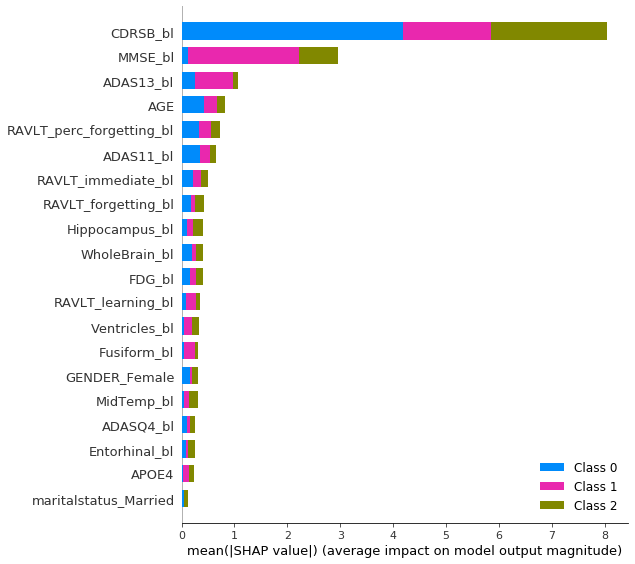

In [40]:
classifier_name_abbr = 'xgboost'

f = plt.figure()
shap.summary_plot(shap_values, X_test)
f.savefig(f"../figs/{classifier_name_abbr}/summary_plot_{classifier_name_abbr}.png", bbox_inches='tight', dpi=600) 

# Generate the force plots

In [43]:
for class_idx in class_idx_to_name.keys():
    print(class_idx_to_name[class_idx])
    #f = plt.figure()
    shap.force_plot(explainer.expected_value[class_idx], shap_values[class_idx], X_test)
    #f.savefig(f"figs/{classifier_name_abbr}/force_plot_{classifier_name_abbr}_{class_idx}_{class_idx_to_name[class_idx]}.png", bbox_inches='tight', dpi=600)

# Generate the foce plots (model output value)

In [53]:
print(class_idx_to_name[0])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

CN


In [54]:
print(class_idx_to_name[1])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)

Dementia


In [55]:
print(class_idx_to_name[2])
shap.force_plot(explainer.expected_value[2], shap_values[2], X_test)

MCI


# Generate the foce plots (variable's effects)

In [56]:
print(class_idx_to_name[0])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

CN


In [57]:
print(class_idx_to_name[1])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)

Dementia


In [58]:
print(class_idx_to_name[2])
shap.force_plot(explainer.expected_value[2], shap_values[2], X_test)

MCI


# Generate the dependence plots

-------------------------------------------------------------------
CN
-------------------------------------------------------------------
****************
CDRSB_bl (CN)
****************


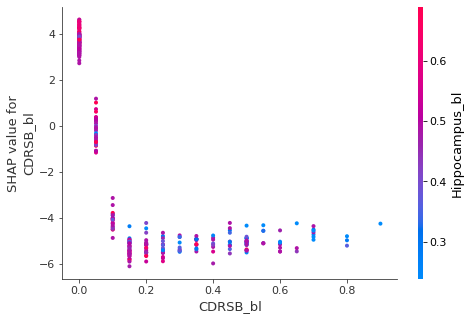

-------------------------------------------------------------------
Dementia
-------------------------------------------------------------------
****************
CDRSB_bl (Dementia)
****************


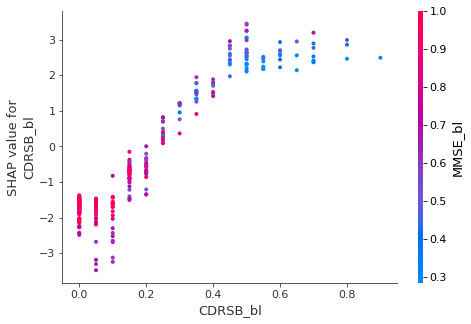

-------------------------------------------------------------------
MCI
-------------------------------------------------------------------
****************
CDRSB_bl (MCI)
****************


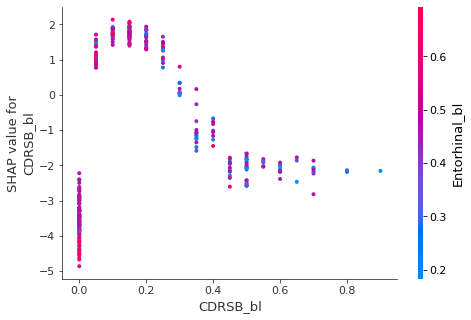

In [52]:
for class_idx in class_idx_to_name.keys():
    print('-------------------------------------------------------------------')    
    print(class_idx_to_name[class_idx])
    print('-------------------------------------------------------------------')
    for colname in X_test.columns:
        if colname == 'CDRSB_bl':
            print('****************')
            print(f"{colname} ({class_idx_to_name[class_idx]})")
            print('****************')
            #f = plt.figure()
            shap.dependence_plot(colname, shap_values[class_idx], X_test)   
            #f.savefig(f"figs/{classifier_name_abbr}/dependence_plot_{classifier_name_abbr}_{class_idx}_{class_idx_to_name[class_idx]}_col-{colname}.png", bbox_inches='tight', dpi=600)     